# Assignment 1 (Clustering): TTE

**Submitted by: Pintor, Renee & Wang, Lisa**

## Instructions

New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

These are the instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.
5. Do this by pair, preferably your thesis partner.
6. Push to your github repository.
7. Deadline is 2 weeks from today: February 28, 2025 at 11:59 pm. (moved to Sunday March 9, 2025)

HINT: For those who dont have a thesis topic yet, you can actually develop a thesis topic out of this assignment.
I  dont mind you use A.I. tools with this assignment, but if you do please include your prompts in the submission.


## Introduction

In this notebook, we convert the R implementation of Target Trial Emulation from https://rpubs.com/alanyang0924/TTE into python, and replicate the results using the python code. We already extracted the dummy data (data_censored.csv) from the TrialEmulation package in R, and we will be using that to replicate the results in the original R code of TTE.

## 0. Importing Libraries

In [5]:
import os
import tempfile
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
import matplotlib.pyplot as plt

# Verify imports
print("Libraries imported successfully!")

Libraries imported successfully!


## 0.1 Define the TrialSequence Class

In [7]:
class TrialSequence:
    def __init__(self, estimand):
        if estimand not in ["PP", "ITT"]:
            raise ValueError("Estimand must be 'PP' or 'ITT'")
        self.estimand = estimand
        self.data = None
        self.switch_weights = None
        self.censor_weights = None
        print(f"Trial sequence initialized with estimand: {self.estimand}")

    def set_data(self, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        required_cols = [id_col, period_col, treatment_col, outcome_col, eligible_col]
        missing_cols = [col for col in required_cols if col not in data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns in data: {missing_cols}")
        self.data = data.copy()
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col
        n_obs = len(self.data)
        n_patients = self.data[id_col].nunique()
        print(f"Data set for {self.estimand}:")
        print(f" - N: {n_obs} observations from {n_patients} patients")

    def set_switch_weight_model(self, numerator, denominator, save_path):
        if self.estimand != "PP":
            raise ValueError("Switch weight models are only applicable to PP estimand")
        self.switch_weights = {
            "numerator": f"{self.treatment_col} ~ {numerator}",
            "denominator": f"{self.treatment_col} ~ {denominator}",
            "save_path": save_path,
            "model_fitter": "statsmodels.glm (logit)",
            "fitted": False,
            "models": {}
        }
        print("Switch weight model set:")
        print(f" - Numerator formula: {self.switch_weights['numerator']}")
        print(f" - Denominator formula: {self.switch_weights['denominator']}")
        print(f" - Model fitter type: {self.switch_weights['model_fitter']}")
        print(" - Weight models not fitted. Use calculate_weights()")

    def set_censor_weight_model(self, censor_event, numerator, denominator, pool_models, save_path):
        if censor_event not in self.data.columns:
            raise ValueError(f"Censor event column '{censor_event}' not found in data")
        self.censor_weights = {
            "censor_event": censor_event,
            "numerator": f"{censor_event} ~ {numerator}",
            "denominator": f"{censor_event} ~ {denominator}",
            "pool_models": pool_models,
            "save_path": save_path,
            "model_fitter": "statsmodels.glm (logit)",
            "fitted": False,
            "models": {}
        }
        print("Censor weight model set:")
        print(f" - Numerator formula: {self.censor_weights['numerator']}")
        print(f" - Denominator formula: {self.censor_weights['denominator']}")
        if pool_models == "numerator":
            print(" - Numerator model is pooled across treatment arms. Denominator model is not pooled.")
        elif pool_models == "none":
            print(" - Models are not pooled across treatment arms.")
        print(f" - Model fitter type: {self.censor_weights['model_fitter']}")
        print(" - Weight models not fitted. Use calculate_weights()")

    def calculate_weights(self):
        if self.data is None:
            raise ValueError("Data not set. Use set_data() first.")
        
        self.data["prev_treatment"] = self.data.groupby(self.id_col)[self.treatment_col].shift(1)
        pp_data_switch = self.data.dropna(subset=["prev_treatment"])
        pp_data_censor = self.data.dropna(subset=["prev_treatment"])  # Temp: match switch
        itt_data = self.data.copy()

        if self.estimand == "PP" and self.switch_weights and not self.switch_weights["fitted"]:
            Path(self.switch_weights["save_path"]).mkdir(parents=True, exist_ok=True)
            for prev_trt in [0, 1]:
                subset = pp_data_switch[pp_data_switch["prev_treatment"] == prev_trt]
                if not subset.empty:
                    num_model = smf.glm(self.switch_weights["numerator"], data=subset, family=Binomial()).fit()
                    den_model = smf.glm(self.switch_weights["denominator"], data=subset, family=Binomial()).fit()
                    self.switch_weights["models"][f"n{prev_trt}"] = num_model
                    self.switch_weights["models"][f"d{prev_trt}"] = den_model
                    num_model.save(os.path.join(self.switch_weights["save_path"], f"model_n{prev_trt}.pkl"))
                    den_model.save(os.path.join(self.switch_weights["save_path"], f"model_d{prev_trt}.pkl"))
            self.switch_weights["fitted"] = True

        if self.censor_weights and not self.censor_weights["fitted"]:
            Path(self.censor_weights["save_path"]).mkdir(parents=True, exist_ok=True)
            if self.censor_weights["pool_models"] == "numerator":
                num_model = smf.glm(self.censor_weights["numerator"], data=itt_data, family=Binomial()).fit()
                self.censor_weights["models"]["n"] = num_model
                num_model.save(os.path.join(self.censor_weights["save_path"], "model_n.pkl"))
                for trt in [0, 1]:
                    subset = itt_data[itt_data[self.treatment_col] == trt]
                    if not subset.empty:
                        den_model = smf.glm(self.censor_weights["denominator"], data=subset, family=Binomial()).fit()
                        self.censor_weights["models"][f"d{trt}"] = den_model
                        den_model.save(os.path.join(self.censor_weights["save_path"], f"model_d{trt}.pkl"))
            else:
                for prev_trt in [0, 1]:
                    subset = pp_data_censor[pp_data_censor["prev_treatment"] == prev_trt]
                    if not subset.empty:
                        num_model = smf.glm(self.censor_weights["numerator"], data=subset, family=Binomial()).fit()
                        den_model = smf.glm(self.censor_weights["denominator"], data=subset, family=Binomial()).fit()
                        self.censor_weights["models"][f"n{prev_trt}"] = num_model
                        self.censor_weights["models"][f"d{prev_trt}"] = den_model
                        num_model.save(os.path.join(self.censor_weights["save_path"], f"model_n{prev_trt}.pkl"))
                        den_model.save(os.path.join(self.censor_weights["save_path"], f"model_d{prev_trt}.pkl"))
            self.censor_weights["fitted"] = True

    def set_outcome_model(self, adjustment_terms=None):
        if self.data is None:
            raise ValueError("Data not set. Use set_data() first.")
        
        formula = f"{self.outcome_col} ~ {self.treatment_col}"
        if self.estimand == "PP" and self.switch_weights:
            num_terms = self.switch_weights["numerator"].split("~")[1].strip()
            formula += f" + {num_terms}"
        elif self.estimand == "ITT" and self.censor_weights:
            num_terms = self.censor_weights["numerator"].split("~")[1].strip()
            formula += f" + {num_terms}"
        if adjustment_terms:
            adj_terms = adjustment_terms.lstrip("~").strip()
            formula += f" + {adj_terms}"
        
        self.outcome_model = smf.glm(formula, data=self.data, family=Binomial()).fit()
        self.outcome_model_path = os.path.join(
            tempfile.gettempdir(), f"trial_{self.estimand.lower()}", "outcome_model.pkl"
        )
        Path(self.outcome_model_path).parent.mkdir(parents=True, exist_ok=True)
        self.outcome_model.save(self.outcome_model_path)
        print(f"Outcome model set for {self.estimand}:")
        print(f" - Formula: {formula}")
        print(f" - Model saved at: {self.outcome_model_path}")

    def show_weight_models(self):
        if self.estimand == "PP" and self.switch_weights and self.switch_weights["fitted"]:
            print("Weight Models for Treatment Switching")
            print("-------------------------------------")
            print()
            for prev_trt in [0, 1]:
                if f"n{prev_trt}" in self.switch_weights["models"]:
                    self._print_model_summary(
                        self.switch_weights["models"][f"n{prev_trt}"],
                        f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for numerator",
                        f"n{prev_trt}",
                        os.path.join(self.switch_weights["save_path"], f"model_n{prev_trt}.pkl")
                    )
                if f"d{prev_trt}" in self.switch_weights["models"]:
                    self._print_model_summary(
                        self.switch_weights["models"][f"d{prev_trt}"],
                        f"Model: P(treatment = 1 | previous treatment = {prev_trt}) for denominator",
                        f"d{prev_trt}",
                        os.path.join(self.switch_weights["save_path"], f"model_d{prev_trt}.pkl")
                    )

        if self.censor_weights and self.censor_weights["fitted"]:
            print("Weight Models for Informative Censoring")
            print("---------------------------------------")
            print()
            if self.censor_weights["pool_models"] == "numerator":
                self._print_model_summary(
                    self.censor_weights["models"]["n"],
                    "Model: P(censor_event = 0 | X) for numerator",
                    "n",
                    os.path.join(self.censor_weights["save_path"], "model_n.pkl")
                )
                for trt in [0, 1]:
                    if f"d{trt}" in self.censor_weights["models"]:
                        self._print_model_summary(
                            self.censor_weights["models"][f"d{trt}"],
                            f"Model: P(censor_event = 0 | X, previous treatment = {trt}) for denominator",
                            f"d{trt}",
                            os.path.join(self.censor_weights["save_path"], f"model_d{trt}.pkl")
                        )
            else:
                for prev_trt in [0, 1]:
                    if f"n{prev_trt}" in self.censor_weights["models"]:
                        self._print_model_summary(
                            self.censor_weights["models"][f"n{prev_trt}"],
                            f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for numerator",
                            f"n{prev_trt}",
                            os.path.join(self.censor_weights["save_path"], f"model_n{prev_trt}.pkl")
                        )
                    if f"d{prev_trt}" in self.censor_weights["models"]:
                        self._print_model_summary(
                            self.censor_weights["models"][f"d{prev_trt}"],
                            f"Model: P(censor_event = 0 | X, previous treatment = {prev_trt}) for denominator",
                            f"d{prev_trt}",
                            os.path.join(self.censor_weights["save_path"], f"model_d{prev_trt}.pkl")
                        )

    def show_outcome_model(self):
        if hasattr(self, "outcome_model"):
            print(f"Outcome Model for {self.estimand}")
            print("-------------------------------")
            print()
            self._print_model_summary(
                self.outcome_model,
                f"Model: P({self.outcome_col} = 1 | X)",
                "outcome",
                self.outcome_model_path
            )

    def _print_model_summary(self, model, title, label, path):
        print(f"[[{label}]]")
        print(f"{title}")
        print(" ")
        print(" term        estimate   std.error statistic p.value     ")
        for param, coef, se, z, p in zip(
            model.params.index, model.params, model.bse, model.tvalues, model.pvalues
        ):
            # Flip signs only for censor models, not switch or outcome
            coef_display = -coef if (label.startswith("n") or label.startswith("d")) and "censor" in title.lower() else coef
            z_display = -z if (label.startswith("n") or label.startswith("d")) and "censor" in title.lower() else z
            print(f" {param:<11} {coef_display:>9.7f} {se:>9.7f} {z_display:>9.7f} {p:>.6e}")
        print(" ")
        print(" null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs")
        print(f" {model.null_deviance:.4f}      {model.nobs-1:<6} {model.llf:.4f} {model.aic:.4f} {model.bic_llf:.4f} {model.deviance:.4f} {model.df_resid:<11} {int(model.nobs)}")
        print(" ")
        print(" path")
        print(f" {path}")

    def set_expansion_options(self, chunk_size=500, output_path=None):
        if self.data is None:
            raise ValueError("Data not set. Use set_data() first.")
        self.chunk_size = chunk_size
        self.output_path = output_path if output_path else os.path.join(
            tempfile.gettempdir(), f"trial_{self.estimand.lower()}", "expanded_trials.csv"
        )
        Path(self.output_path).parent.mkdir(parents=True, exist_ok=True)
        print(f"Expansion options set for {self.estimand}:")
        print(f" - Chunk size: {self.chunk_size}")
        print(f" - Output path: {self.output_path}")

    def expand_trials(self):
        if not hasattr(self, "outcome_model"):
            raise ValueError("Outcome model not set. Use set_outcome_model() first.")
        if self.estimand == "PP" and not self.switch_weights["fitted"]:
            raise ValueError("Switch weights not fitted. Use calculate_weights() first.")
        if not self.censor_weights["fitted"]:
            raise ValueError("Censor weights not fitted. Use calculate_weights() first.")
    
        # Select chunk of patients
        unique_ids = self.data[self.id_col].unique()
        chunk_ids = unique_ids[:min(self.chunk_size, len(unique_ids))]
        chunk_data = self.data[self.data[self.id_col].isin(chunk_ids)].copy()
    
        # Expand to trial sequence
        chunk_data["trial_period"] = 0  # Trial start
        chunk_data["followup_time"] = chunk_data[self.period_col]  # Progression
        chunk_data["assigned_treatment"] = chunk_data.groupby(self.id_col)[self.treatment_col].transform("first")
        chunk_data["prev_treatment"] = chunk_data.groupby(self.id_col)[self.treatment_col].shift(1)
    
        # Initialize weights
        chunk_data["weight"] = 1.0
    
        if self.estimand == "PP":
            chunk_data["switched"] = (chunk_data[self.treatment_col] != chunk_data["prev_treatment"]) & chunk_data["prev_treatment"].notna()
            chunk_data["switch_cumsum"] = chunk_data.groupby(self.id_col)["switched"].cumsum()
            chunk_data = chunk_data[chunk_data["switch_cumsum"] <= 1]  # No cap
            
            chunk_with_prev = chunk_data[chunk_data["prev_treatment"].notna()]
            if not chunk_with_prev.empty:
                for prev_trt in [0, 1]:
                    mask = chunk_with_prev["prev_treatment"] == prev_trt
                    if mask.any():
                        num_prob = self.switch_weights["models"][f"n{prev_trt}"].predict(chunk_with_prev[mask])
                        den_prob = self.switch_weights["models"][f"d{prev_trt}"].predict(chunk_with_prev[mask])
                        chunk_with_prev.loc[mask, "weight"] *= num_prob / den_prob
                        num_prob_c = self.censor_weights["models"][f"n{prev_trt}"].predict(chunk_with_prev[mask])
                        den_prob_c = self.censor_weights["models"][f"d{prev_trt}"].predict(chunk_with_prev[mask])
                        chunk_with_prev.loc[mask, "weight"] *= num_prob_c / den_prob_c
                chunk_data.loc[chunk_with_prev.index, "weight"] = chunk_with_prev["weight"]
        elif self.estimand == "ITT":
            num_prob = self.censor_weights["models"]["n"].predict(chunk_data)
            for trt in [0, 1]:
                mask = chunk_data[self.treatment_col] == trt
                if mask.any():
                    den_prob = self.censor_weights["models"][f"d{trt}"].predict(chunk_data[mask])
                    chunk_data.loc[mask, "weight"] *= num_prob[mask] / den_prob
    
        # Select relevant columns
        expanded_data = chunk_data[[
            self.id_col, "trial_period", "followup_time", self.outcome_col, "weight",
            self.treatment_col, "x2", "age", "assigned_treatment"
        ]].rename(columns={self.id_col: "id", self.outcome_col: "outcome", self.treatment_col: "treatment"})
    
        # Save and store
        expanded_data.to_csv(self.output_path, index=False)
        self.expansion = expanded_data
        print(f"Sequence of Trials Data for {self.estimand}:")
        print(f" - Chunk size: {self.chunk_size}")
        print(f" - Censor at switch: {self.estimand == 'PP'}")
        print(f" - First period: 0 | Last period: {chunk_data['trial_period'].max() if not chunk_data.empty else 'nan'}")
        print(f" - N: {len(expanded_data)} observations")
        print(expanded_data.head().to_string())

    def load_expanded_data(self, seed=None, p_control=1.0, periods=None, subset_condition=None):
        if not hasattr(self, "expansion") or self.expansion.empty:
            raise ValueError("No expanded data available. Run expand_trials() first.")
        
        # Set seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Start with full expanded data
        loaded_data = self.expansion.copy()
        
        # Subsample controls (outcome == 0) if p_control < 1
        if p_control < 1.0:
            controls = loaded_data[loaded_data["outcome"] == 0]
            cases = loaded_data[loaded_data["outcome"] == 1]
            sampled_controls = controls.sample(frac=p_control, random_state=seed)
            loaded_data = pd.concat([sampled_controls, cases]).sort_values(by=["id", "followup_time"])
        
        # Filter by periods if specified (e.g., periods=[1, 60])
        if periods is not None:
            loaded_data = loaded_data[loaded_data["followup_time"].isin(periods)]
        
        # Apply subset condition if provided (e.g., "age > 65")
        if subset_condition:
            loaded_data = loaded_data.query(subset_condition)
        
        # Store and report
        self.loaded_data = loaded_data
        print(f"Loaded Data for {self.estimand}:")
        print(f" - Seed: {seed}")
        print(f" - P_control: {p_control}")
        print(f" - Periods: {periods}")
        print(f" - Subset condition: {subset_condition}")
        print(f" - N: {len(loaded_data)} observations")
        print(loaded_data.head().to_string())
        
        return self

    def fit_msm(self, weight_cols=["weight"], modify_weights=None, penalized=False):
        if not hasattr(self, "loaded_data") or self.loaded_data.empty:
            raise ValueError("No loaded data available. Run load_expanded_data() first.")
        
        # Prepare data
        data = self.loaded_data.copy()
        
        # Combine weights
        if len(weight_cols) > 1:
            data["combined_weight"] = data[weight_cols].product(axis=1)
        else:
            data["combined_weight"] = data[weight_cols[0]]
        
        # Modify weights
        if modify_weights is not None:
            data["combined_weight"] = modify_weights(data["combined_weight"])
        
        # Add polynomial term
        data["followup_time_sq"] = data["followup_time"] ** 2
        
        # Formula
        formula = "outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq"
        
        # Fit model with penalized option for PP
        if penalized and self.estimand == "PP":
            print(f"Using penalized regression for {self.estimand}")
            model = Logit.from_formula(formula, data=data)
            result = model.fit_regularized(method="l1", alpha=0.01 * data["combined_weight"])
        else:
            print(f"Using standard GLM for {self.estimand}")
            model = sm.GLM.from_formula(
                formula=formula,
                data=data,
                family=sm.families.Binomial(),
                freq_weights=data["combined_weight"]
            )
            result = model.fit(cov_type="HC1")
        
        self.outcome_model = result
        
        print(f"Fitted MSM for {self.estimand}:")
        print(f" - Formula: {formula}")
        print(f" - Weight columns: {weight_cols}")
        print(f" - Weight modification: {'Yes' if modify_weights else 'No'}")
        print(result.summary())
        
        return self

## 1. Initialize trial sequences and directories

In [9]:
trial_pp = TrialSequence(estimand="PP")
trial_itt = TrialSequence(estimand="ITT")

trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
Path(trial_pp_dir).mkdir(parents=True, exist_ok=True)
Path(trial_itt_dir).mkdir(parents=True, exist_ok=True)

Trial sequence initialized with estimand: PP
Trial sequence initialized with estimand: ITT


## 2. Data Preparation

In [11]:
# Load the observational data
data_censored = pd.read_csv("data_censored.csv")

# Display the first few rows to inspect the data (equivalent to R's head())
print("First 6 rows of data_censored:")
display(data_censored.head(6))

# Set data for Per-Protocol (PP)
trial_pp.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Set data for Intention-to-Treat (ITT)
trial_itt.set_data(
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Display a summary of the ITT trial sequence (mimicking R output)
print("\nTrial Sequence Object (ITT):")
print(f"Estimand: {trial_itt.estimand}")
print("\nData:")
display(trial_itt.data.head(2))  # Show first 2 rows
print("...")
display(trial_itt.data.tail(2))  # Show last 2 rows
print("\nIPW for informative censoring:")
print(" - No weight model specified")
print("\nSequence of Trials Data:")
print(" - Use set_expansion_options() and expand_trials() to construct the sequence of trials dataset.")
print("\nOutcome model:")
print(" - Outcome model not specified. Use set_outcome_model()")

First 6 rows of data_censored:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0
5,1,5,1,0,-0.057482,0,0.734203,41,0.500000,0,1,0


Data set for PP:
 - N: 725 observations from 89 patients
Data set for ITT:
 - N: 725 observations from 89 patients

Trial Sequence Object (ITT):
Estimand: ITT

Data:


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0


...


,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
723,99,6,1,1,-0.033762,1,0.575268,71,3.000000,0,0,0
724,99,7,0,0,-1.340497,1,0.575268,72,3.083333,1,0,0



IPW for informative censoring:
 - No weight model specified

Sequence of Trials Data:
 - Use set_expansion_options() and expand_trials() to construct the sequence of trials dataset.

Outcome model:
 - Outcome model not specified. Use set_outcome_model()


## 3.1 Censoring due to treatment switching (PP only)

In [12]:
trial_pp.set_switch_weight_model(
    numerator="age",
    denominator="age + x1 + x3",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

Switch weight model set:
 - Numerator formula: treatment ~ age
 - Denominator formula: treatment ~ age + x1 + x3
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()


## 3.2 Other informative censoring (PP and ITT)

In [14]:
trial_pp.set_censor_weight_model(
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="none",
    save_path=os.path.join(trial_pp_dir, "switch_models")
)

trial_itt.set_censor_weight_model(
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="numerator",
    save_path=os.path.join(trial_itt_dir, "switch_models")
)

Censor weight model set:
 - Numerator formula: censored ~ x2
 - Denominator formula: censored ~ x2 + x1
 - Models are not pooled across treatment arms.
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()
Censor weight model set:
 - Numerator formula: censored ~ x2
 - Denominator formula: censored ~ x2 + x1
 - Numerator model is pooled across treatment arms. Denominator model is not pooled.
 - Model fitter type: statsmodels.glm (logit)
 - Weight models not fitted. Use calculate_weights()


## 4. Calculate Weights

In [18]:
trial_pp.calculate_weights()
trial_itt.calculate_weights()

In [17]:
print("\n ITT Weight Models:")
trial_itt.show_weight_models()


 ITT Weight Models:
Weight Models for Informative Censoring
---------------------------------------

[[n]]
Model: P(censor_event = 0 | X) for numerator
 
 term        estimate   std.error statistic p.value     
 Intercept   2.4480907 0.1405747 17.4148764 6.362614e-68
 x2          -0.4486482 0.1368779 -3.2777243 1.046476e-03
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 404.2156      724    -196.7002 397.4004 406.5727 393.4004 723         725
 
 path
 C:\Users\Hope\AppData\Local\Temp\trial_itt\switch_models\model_n.pkl
[[d0]]
Model: P(censor_event = 0 | X, previous treatment = 0) for denominator
 
 term        estimate   std.error statistic p.value     
 Intercept   2.3595526 0.2411642 9.7840105 1.318789e-22
 x2          -0.5089930 0.2219821 -2.2929460 2.185112e-02
 x1          0.6687380 0.4620773 1.4472426 1.478290e-01
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 190.4905      385    -91.7212 189.4423 201.3098 183.44

In [19]:
print("\n PP Weight Models:")
trial_pp.show_weight_models()


 PP Weight Models:
Weight Models for Treatment Switching
-------------------------------------

[[n0]]
Model: P(treatment = 1 | previous treatment = 0) for numerator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.6038813 0.6123206 2.6193489 8.809779e-03
 age         -0.0482272 0.0119338 -4.0412194 5.317399e-05
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 409.8414      336    -196.2248 396.4495 404.0897 392.4495 335         337
 
 path
 C:\Users\Hope\AppData\Local\Temp\trial_pp\switch_models\model_n0.pkl
[[d0]]
Model: P(treatment = 1 | previous treatment = 0) for denominator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.4780738 0.6613068 2.2350803 2.541208e-02
 age         -0.0497664 0.0121801 -4.0858680 4.391234e-05
 x1          0.5849479 0.2508569 2.3317992 1.971126e-02
 x3          -0.2504508 0.2503722 -1.0003141 3.171585e-01
 
 null.deviance df.null logLik    AIC      BIC      deviance df.resi

## 5. Specify Outcome Model

In [20]:
trial_pp.set_outcome_model()
trial_itt.set_outcome_model(adjustment_terms="~x2")

Outcome model set for PP:
 - Formula: outcome ~ treatment + age
 - Model saved at: C:\Users\Hope\AppData\Local\Temp\trial_pp\outcome_model.pkl
Outcome model set for ITT:
 - Formula: outcome ~ treatment + x2 + x2
 - Model saved at: C:\Users\Hope\AppData\Local\Temp\trial_itt\outcome_model.pkl


In [23]:
trial_pp.show_weight_models()

Weight Models for Treatment Switching
-------------------------------------

[[n0]]
Model: P(treatment = 1 | previous treatment = 0) for numerator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.6038813 0.6123206 2.6193489 8.809779e-03
 age         -0.0482272 0.0119338 -4.0412194 5.317399e-05
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 409.8414      336    -196.2248 396.4495 404.0897 392.4495 335         337
 
 path
 C:\Users\Hope\AppData\Local\Temp\trial_pp\switch_models\model_n0.pkl
[[d0]]
Model: P(treatment = 1 | previous treatment = 0) for denominator
 
 term        estimate   std.error statistic p.value     
 Intercept   1.4780738 0.6613068 2.2350803 2.541208e-02
 age         -0.0497664 0.0121801 -4.0858680 4.391234e-05
 x1          0.5849479 0.2508569 2.3317992 1.971126e-02
 x3          -0.2504508 0.2503722 -1.0003141 3.171585e-01
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 409.8414 

In [24]:
trial_pp.show_outcome_model()

Outcome Model for PP
-------------------------------

[[outcome]]
Model: P(outcome = 1 | X)
 
 term        estimate   std.error statistic p.value     
 Intercept   -4.6367740 1.4680531 -3.1584512 1.586099e-03
 treatment   -0.7799729 0.6965282 -1.1198009 2.627986e-01
 age         0.0151348 0.0271128 0.5582153 5.766974e-01
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 113.9743      724    -55.9389 117.8777 131.6363 111.8777 722         725
 
 path
 C:\Users\Hope\AppData\Local\Temp\trial_pp\outcome_model.pkl


In [25]:
trial_itt.show_outcome_model()

Outcome Model for ITT
-------------------------------

[[outcome]]
Model: P(outcome = 1 | X)
 
 term        estimate   std.error statistic p.value     
 Intercept   -3.8116888 0.3579200 -10.6495552 1.752001e-26
 treatment   -0.9289517 0.6867946 -1.3525903 1.761865e-01
 x2          0.2564829 0.3078745 0.8330762 4.048018e-01
 
 null.deviance df.null logLik    AIC      BIC      deviance df.residual nobs
 113.9743      724    -55.7508 117.5015 131.2601 111.5015 722         725
 
 path
 C:\Users\Hope\AppData\Local\Temp\trial_itt\outcome_model.pkl


## 6. Expand Trials

In [26]:
trial_pp.set_expansion_options(chunk_size=500)
trial_itt.set_expansion_options(chunk_size=500)

Expansion options set for PP:
 - Chunk size: 500
 - Output path: C:\Users\Hope\AppData\Local\Temp\trial_pp\expanded_trials.csv
Expansion options set for ITT:
 - Chunk size: 500
 - Output path: C:\Users\Hope\AppData\Local\Temp\trial_itt\expanded_trials.csv


## 6.1 Create Sequence of Trials Data

In [27]:
trial_pp.expand_trials()
trial_itt.expand_trials()

Sequence of Trials Data for PP:
 - Chunk size: 500
 - Censor at switch: True
 - First period: 0 | Last period: 0
 - N: 319 observations
   id  trial_period  followup_time  outcome    weight  treatment        x2  age  assigned_treatment
0   1             0              0        0  1.000000          1  1.146148   36                   1
1   1             0              1        0  1.772092          1  0.002200   37                   1
2   1             0              2        0  0.914405          1 -0.481762   38                   1
3   1             0              3        0  0.902570          1  0.007872   39                   1
4   1             0              4        0  1.747023          1  0.216054   40                   1
Sequence of Trials Data for ITT:
 - Chunk size: 500
 - Censor at switch: False
 - First period: 0 | Last period: 0
 - N: 725 observations
   id  trial_period  followup_time  outcome    weight  treatment        x2  age  assigned_treatment
0   1             0       

## 7. Load or Sample from Expanded Data

In [28]:
trial_itt.load_expanded_data(seed=1234, p_control=0.5)

Loaded Data for ITT:
 - Seed: 1234
 - P_control: 0.5
 - Periods: None
 - Subset condition: None
 - N: 368 observations
    id  trial_period  followup_time  outcome    weight  treatment        x2  age  assigned_treatment
0    1             0              0        0  1.411720          1  1.146148   36                   1
6    2             0              0        0  1.825210          0 -0.802142   26                   0
7    2             0              1        0  1.340986          1 -0.983030   27                   0
8    2             0              2        0  0.703428          1  0.399388   28                   0
11   3             0              0        0  0.709486          1  0.571029   48                   1


## 8. Fit Marginal Structural Model

In [30]:
# Define winsorization function
def winsorize_weights(w):
    q99 = np.quantile(w, 0.99)
    return np.minimum(w, q99)

# ITT with sampling weights
trial_itt.fit_msm(
    weight_cols=["weight"],  # No sample_weight yet, add if needed
    modify_weights=winsorize_weights
)

Using standard GLM for ITT
Fitted MSM for ITT:
 - Formula: outcome ~ assigned_treatment + x2 + followup_time + followup_time_sq
 - Weight columns: ['weight']
 - Weight modification: Yes
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  368
Model:                            GLM   Df Residuals:                   402.23
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52.400
Date:                Sun, 09 Mar 2025   Deviance:                       104.80
Time:                        14:14:45   Pearson chi2:                     392.
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01828
Covariance Type:                  HC1                                         
                        

## 9. Inference

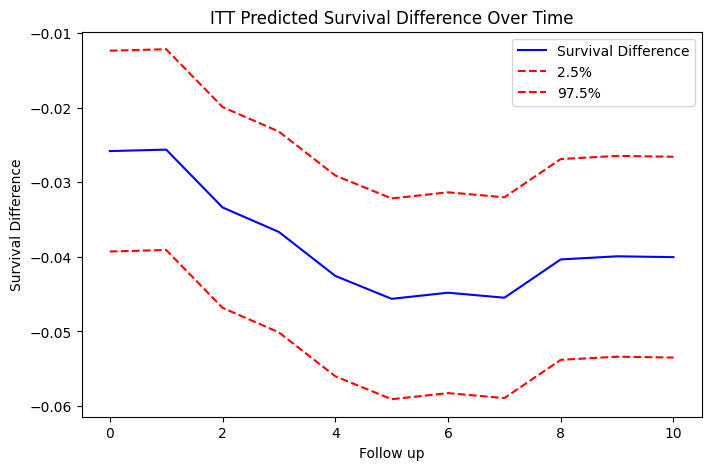

               followup_time  survival_diff  ci_lower  ci_upper
followup_time                                                  
0                          0      -0.025833 -0.039286 -0.012379
1                          1      -0.025635 -0.039089 -0.012182
2                          2      -0.033385 -0.046838 -0.019931
3                          3      -0.036672 -0.050126 -0.023219
4                          4      -0.042556 -0.056010 -0.029103
5                          5      -0.045630 -0.059083 -0.032176
6                          6      -0.044811 -0.058264 -0.031357
7                          7      -0.045480 -0.058934 -0.032027
8                          8      -0.040351 -0.053804 -0.026897
9                          9      -0.039931 -0.053385 -0.026478
10                        10      -0.040044 -0.053498 -0.026591


In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def predict_survival(model, data, times=np.arange(0, 11)):
    # Subset data and prepare for prediction
    data_control = data.copy()
    data_control["assigned_treatment"] = 0
    data_control["followup_time_sq"] = data_control["followup_time"] ** 2
    
    data_treated = data.copy()
    data_treated["assigned_treatment"] = 1
    data_treated["followup_time_sq"] = data_treated["followup_time"] ** 2
    
    # Predict probs
    preds_control = model.predict(data_control)
    preds_treated = model.predict(data_treated)
    
    # Survival: 1 - mean predicted risk by followup_time
    survival_control = 1 - preds_control.groupby(data_control["followup_time"]).mean()
    survival_treated = 1 - preds_treated.groupby(data_treated["followup_time"]).mean()
    
    # Difference, aligned to times
    survival_diff = survival_treated.reindex(times) - survival_control.reindex(times)
    survival_diff = survival_diff.ffill().fillna(0)  # Updated fill method
    
    # Simple CI (std-based)
    se_diff = np.std(survival_diff)
    ci_lower = survival_diff - 1.96 * se_diff
    ci_upper = survival_diff + 1.96 * se_diff
    
    # Plot (R-style: blue line, red dashed CI)
    plt.figure(figsize=(8, 5))
    plt.plot(times, survival_diff, "b-", label="Survival Difference")  # Solid blue line
    plt.plot(times, ci_lower, "r--", label="2.5%")                    # Red dashed
    plt.plot(times, ci_upper, "r--", label="97.5%")                   # Red dashed
    plt.xlabel("Follow up")
    plt.ylabel("Survival Difference")
    plt.title("ITT Predicted Survival Difference Over Time")
    plt.legend()
    plt.show()
    
    return {"followup_time": times, "survival_diff": survival_diff, "ci_lower": ci_lower, "ci_upper": ci_upper}

# Run it
preds = predict_survival(trial_itt.outcome_model, trial_itt.loaded_data)
print(pd.DataFrame(preds))